# Model Evaluation and Comparison

Compare logistic regression and MLP performance using ROC curves, precision-recall curves, calibration plots, and performance metrics.

In [1]:
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.calibration import calibration_curve
from sklearn.metrics import roc_curve, precision_recall_curve, auc

sns.set_style("whitegrid")

# Configuration
DATA_DIR = "../data"
RESULTS_DIR = "../results"
FIGURES_DIR = os.path.join(RESULTS_DIR, "figures")

VAL_FILE = os.path.join(DATA_DIR, "val.csv")
LOGISTIC_PREDICTIONS = os.path.join(RESULTS_DIR, "logistic_predictions.csv")
MLP_PREDICTIONS = os.path.join(RESULTS_DIR, "mlp_predictions.csv")
LOGISTIC_METRICS = os.path.join(RESULTS_DIR, "logistic_metrics.json")
MLP_METRICS = os.path.join(RESULTS_DIR, "mlp_metrics.json")

TARGET_COL = "status"

os.makedirs(FIGURES_DIR, exist_ok=True)

In [2]:
# Load data
val_df = pd.read_csv(VAL_FILE)
y_true = val_df[TARGET_COL].values

logistic_df = pd.read_csv(LOGISTIC_PREDICTIONS)
mlp_df = pd.read_csv(MLP_PREDICTIONS)

y_proba_logistic = logistic_df['predicted_probability'].values
y_proba_mlp = mlp_df['predicted_probability'].values

with open(LOGISTIC_METRICS, 'r') as f:
    logistic_metrics = json.load(f)

with open(MLP_METRICS, 'r') as f:
    mlp_metrics = json.load(f)

print(f"Validation samples: {len(y_true)}")
print(f"Positive class: {np.sum(y_true)} ({np.mean(y_true)*100:.1f}%)")

Validation samples: 14867
Positive class: 3664 (24.6%)


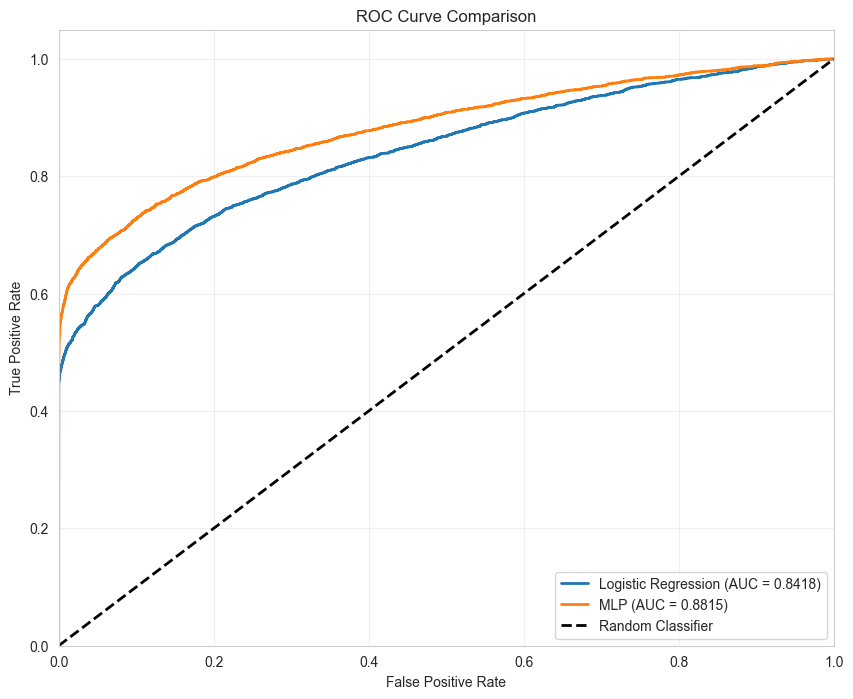

Logistic Regression AUC-ROC: 0.8418
MLP AUC-ROC: 0.8815
Improvement: 4.72%


In [3]:
# ROC Curve
fpr_log, tpr_log, _ = roc_curve(y_true, y_proba_logistic)
fpr_mlp, tpr_mlp, _ = roc_curve(y_true, y_proba_mlp)

auc_log = auc(fpr_log, tpr_log)
auc_mlp = auc(fpr_mlp, tpr_mlp)

plt.figure(figsize=(10, 8))
plt.plot(fpr_log, tpr_log, lw=2, label=f'Logistic Regression (AUC = {auc_log:.4f})')
plt.plot(fpr_mlp, tpr_mlp, lw=2, label=f'MLP (AUC = {auc_mlp:.4f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.savefig(os.path.join(FIGURES_DIR, 'roc_curve.png'), dpi=300, bbox_inches='tight')
plt.show()

print(f"Logistic Regression AUC-ROC: {auc_log:.4f}")
print(f"MLP AUC-ROC: {auc_mlp:.4f}")
print(f"Improvement: {((auc_mlp - auc_log) / auc_log * 100):.2f}%")

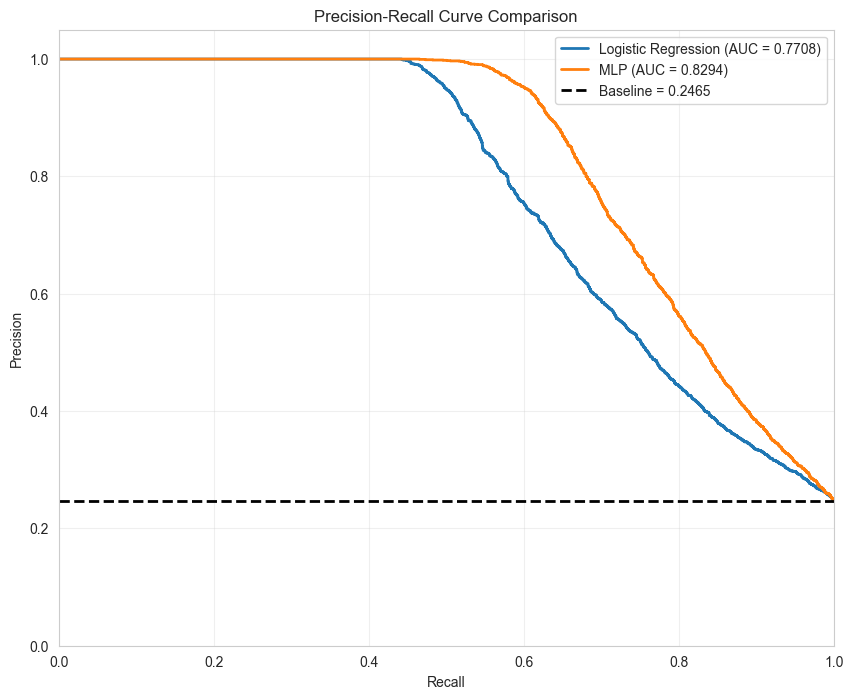

In [4]:
# Precision-Recall Curve
precision_log, recall_log, _ = precision_recall_curve(y_true, y_proba_logistic)
precision_mlp, recall_mlp, _ = precision_recall_curve(y_true, y_proba_mlp)

pr_auc_log = auc(recall_log, precision_log)
pr_auc_mlp = auc(recall_mlp, precision_mlp)
baseline = np.mean(y_true)

plt.figure(figsize=(10, 8))
plt.plot(recall_log, precision_log, lw=2, label=f'Logistic Regression (AUC = {pr_auc_log:.4f})')
plt.plot(recall_mlp, precision_mlp, lw=2, label=f'MLP (AUC = {pr_auc_mlp:.4f})')
plt.axhline(y=baseline, color='k', linestyle='--', lw=2, label=f'Baseline = {baseline:.4f}')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve Comparison')
plt.legend(loc="best")
plt.grid(True, alpha=0.3)
plt.savefig(os.path.join(FIGURES_DIR, 'pr_curve.png'), dpi=300, bbox_inches='tight')
plt.show()

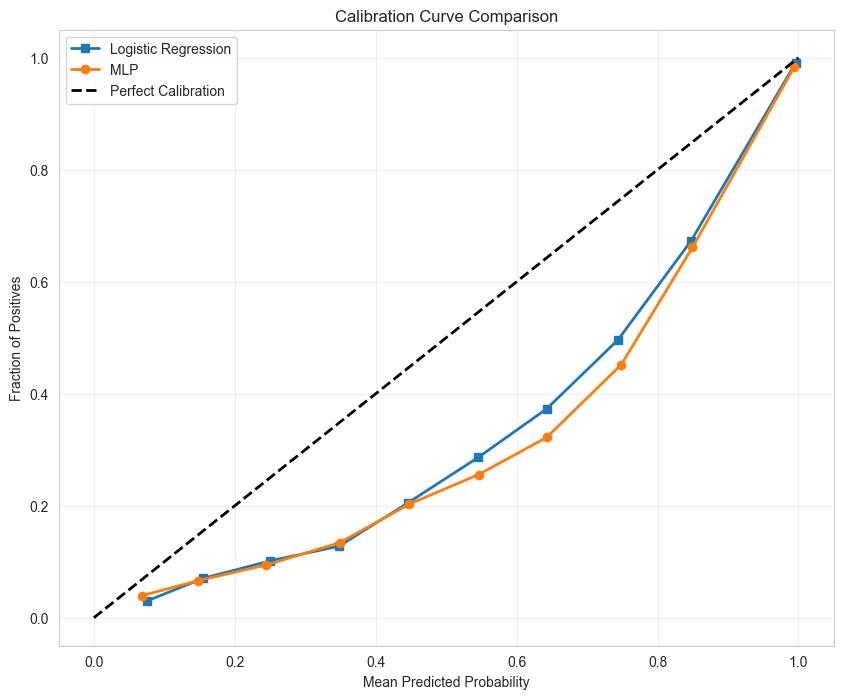

In [5]:
# Calibration Curve
fraction_pos_log, mean_pred_log = calibration_curve(y_true, y_proba_logistic, n_bins=10)
fraction_pos_mlp, mean_pred_mlp = calibration_curve(y_true, y_proba_mlp, n_bins=10)

plt.figure(figsize=(10, 8))
plt.plot(mean_pred_log, fraction_pos_log, 's-', lw=2, label='Logistic Regression')
plt.plot(mean_pred_mlp, fraction_pos_mlp, 'o-', lw=2, label='MLP')
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Perfect Calibration')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title('Calibration Curve Comparison')
plt.legend(loc="best")
plt.grid(True, alpha=0.3)
plt.savefig(os.path.join(FIGURES_DIR, 'calibration_plot.png'), dpi=300, bbox_inches='tight')
plt.show()

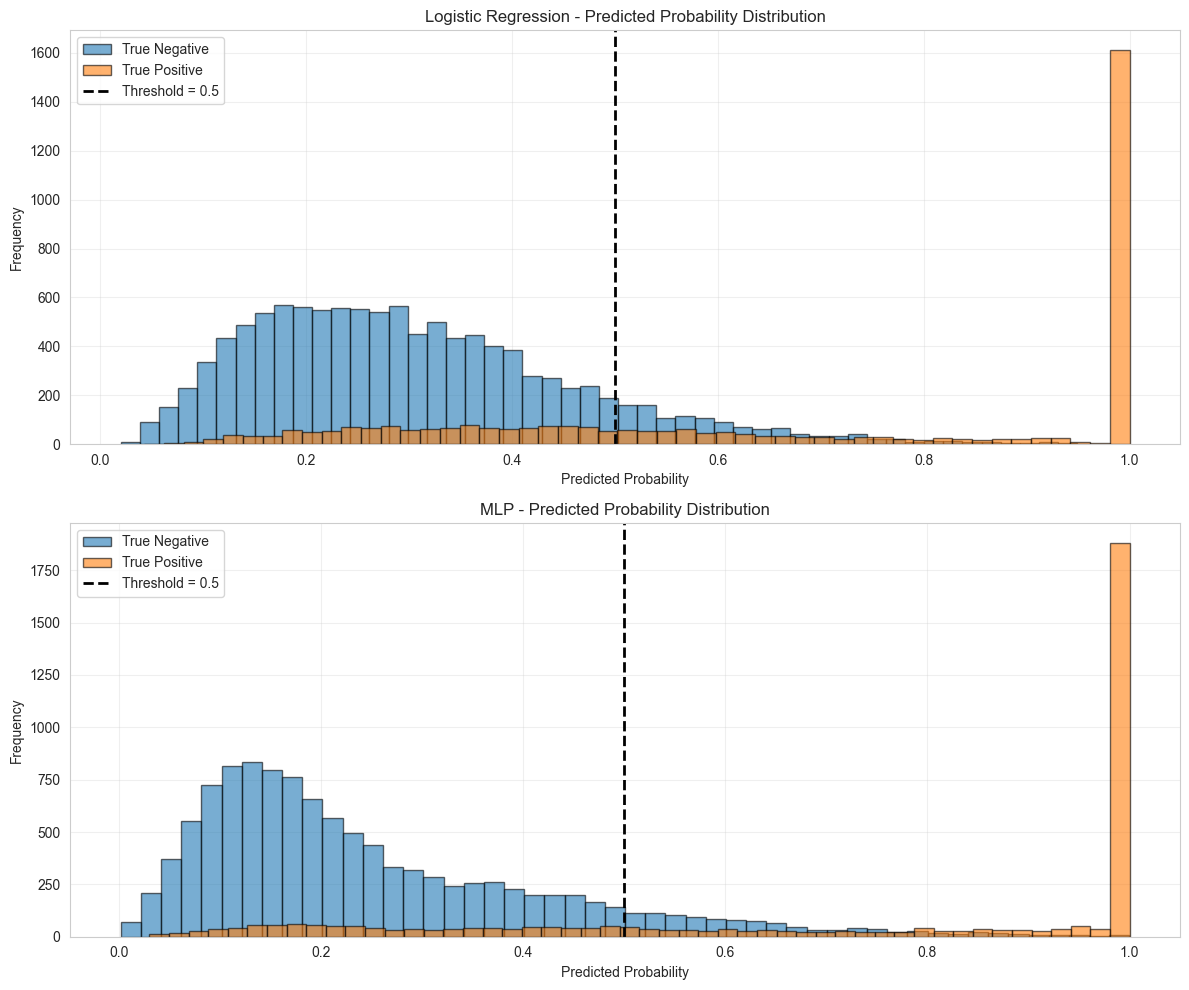

In [6]:
# Probability Distributions
fig, axes = plt.subplots(2, 1, figsize=(12, 10))

# Logistic Regression
axes[0].hist(y_proba_logistic[y_true == 0], bins=50, alpha=0.6, label='True Negative', edgecolor='black')
axes[0].hist(y_proba_logistic[y_true == 1], bins=50, alpha=0.6, label='True Positive', edgecolor='black')
axes[0].axvline(x=0.5, color='black', linestyle='--', lw=2, label='Threshold = 0.5')
axes[0].set_xlabel('Predicted Probability')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Logistic Regression - Predicted Probability Distribution')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# MLP
axes[1].hist(y_proba_mlp[y_true == 0], bins=50, alpha=0.6, label='True Negative', edgecolor='black')
axes[1].hist(y_proba_mlp[y_true == 1], bins=50, alpha=0.6, label='True Positive', edgecolor='black')
axes[1].axvline(x=0.5, color='black', linestyle='--', lw=2, label='Threshold = 0.5')
axes[1].set_xlabel('Predicted Probability')
axes[1].set_ylabel('Frequency')
axes[1].set_title('MLP - Predicted Probability Distribution')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, 'probability_distribution.png'), dpi=300, bbox_inches='tight')
plt.show()

In [7]:
# Model Comparison Table
comparison_data = [
    {
        'Model': 'Logistic Regression',
        'Dataset': 'Validation',
        'AUC-ROC': logistic_metrics['validation_metrics']['auc_roc'],
        'AUC-PR': logistic_metrics['validation_metrics']['auc_pr'],
        'Brier Score': logistic_metrics['validation_metrics']['brier_score']
    },
    {
        'Model': 'Logistic Regression',
        'Dataset': 'Test',
        'AUC-ROC': logistic_metrics['test_metrics']['auc_roc'],
        'AUC-PR': logistic_metrics['test_metrics']['auc_pr'],
        'Brier Score': logistic_metrics['test_metrics']['brier_score']
    },
    {
        'Model': 'MLP',
        'Dataset': 'Validation',
        'AUC-ROC': mlp_metrics['validation_metrics']['auc_roc'],
        'AUC-PR': mlp_metrics['validation_metrics']['auc_pr'],
        'Brier Score': mlp_metrics['validation_metrics']['brier_score']
    },
    {
        'Model': 'MLP',
        'Dataset': 'Test',
        'AUC-ROC': mlp_metrics['test_metrics']['auc_roc'],
        'AUC-PR': mlp_metrics['test_metrics']['auc_pr'],
        'Brier Score': mlp_metrics['test_metrics']['brier_score']
    }
]

comparison_df = pd.DataFrame(comparison_data)
comparison_df.to_csv(os.path.join(RESULTS_DIR, "model_comparison.csv"), index=False)

print("Model Comparison Table:")
print(comparison_df.to_string(index=False))

# Summary
val_data = comparison_df[comparison_df['Dataset'] == 'Validation']
best_model = val_data.loc[val_data['AUC-ROC'].idxmax()]
print(f"\nBest Model (Validation AUC-ROC): {best_model['Model']} ({best_model['AUC-ROC']:.4f})")

Model Comparison Table:
              Model    Dataset  AUC-ROC   AUC-PR  Brier Score
Logistic Regression Validation 0.841803 0.770868     0.133762
Logistic Regression       Test 0.851161 0.780029     0.131235
                MLP Validation 0.881522 0.829451     0.110096
                MLP       Test 0.891702 0.841179     0.107456

Best Model (Validation AUC-ROC): MLP (0.8815)
